# Glacier model
Graphical model for a simple glacier model<br>
P - Precipitaion<br>
T - Temperature<br>
S - Snowfall<br>
M - Galcier-melt<br>
Q - Discharge from glacier<br>
B - Mass balance of glacier<br>

α - degree-day factor<br>
ß - rain-snow limit<br>
γ - melt-threshold<br>

![](PGM.png)

In [151]:
using Turing, Distributions,MCMCChains, Plots, StatsPlots
@model function glacier_model(P,T,Q,mb)
    alpha ~ truncated(Normal(6, 4), 0, 14)
    beta ~ Normal(0,2)#rs_thresh
    gamma ~ Normal(0,2)#mlt_thresh
    
    #alpha = 7 #truncated(Normal(7, 4), 0, 14)
    #rs_thresh = 1
    #mlt_thresh = -1
 
    
    area = 2.1 *1000*1000 # m2
    t_dash_1=T.-beta
    t_dash_2=T.-gamma
            
            
    snow =0.5* P .* (1 .- sign.(t_dash_1))  #mm
    melt = 0.5 * (abs.(t_dash_2).+t_dash_2) * alpha #mm
            
    mb = (snow .- melt)/1000 #m
    Q = melt * area/1000 # m3/day
end


DynamicPPL.ModelGen{var"###generator#649",(:P, :T, :Q, :mb),(),Tuple{}}(##generator#649, NamedTuple())

In [155]:
using DelimitedFiles
#time=1:100
#prec = 100* sin.(time)
#temp = 5 .+ 10*sin.(time)

#Q_dis= 60 * sin.(time)
Q_dis=readdlm("glac_q_syn.txt", '\t', Float64, '\n')
temp=readdlm("temp.txt", '\t', Float64, '\n')
prec=readdlm("prec.txt", '\t', Float64, '\n')
mb_glac=readdlm("mb_syn.txt", '\t', Float64, '\n')

model = glacier_model(prec, temp, Q_dis ,mb_glac)
chain = sample(model, NUTS(0.65), 3_000);

┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference C:\Users\Vikram\.julia\packages\Turing\GMBTf\src\inference\hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\Vikram\.julia\packages\AdvancedHMC\P9wqk\src\hamiltonian.jl:47
Sampling:  15%|███████                                  |  ETA: 0:00:26┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\Vikram\.julia\packages\AdvancedHMC\P9wqk\src\hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:19


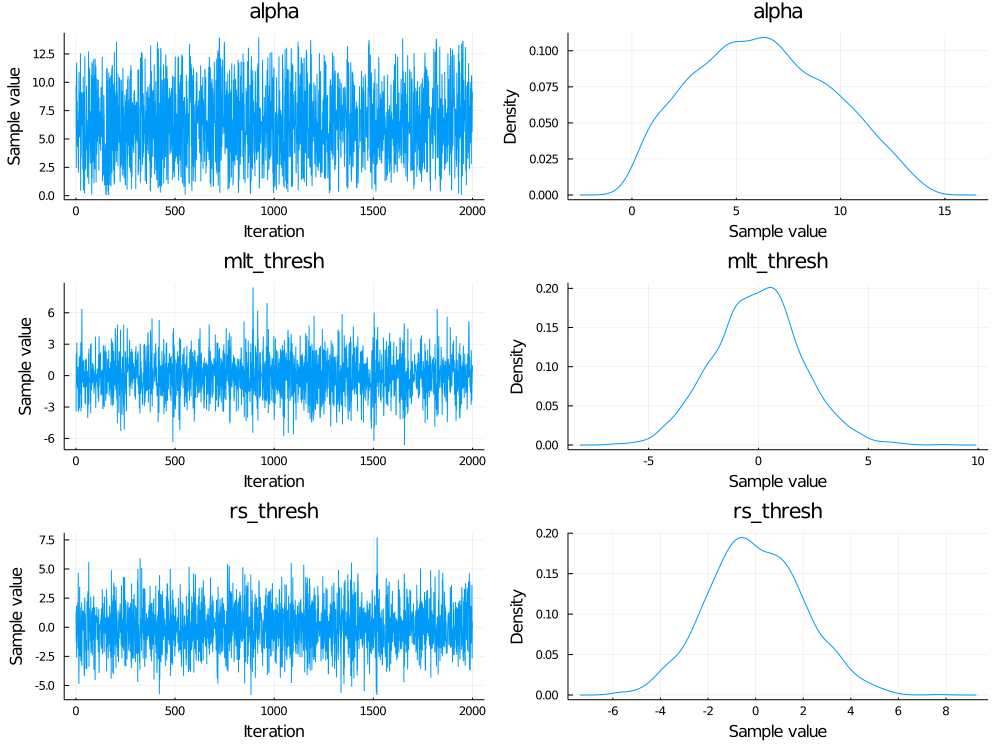

In [156]:
plot(chain)

In [157]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse        ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ─────────  ──────
       alpha   6.2872  3.2430    0.0725  0.0965  2024.7690  0.9995
  mlt_thresh  -0.0463  2.0014    0.0448  0.0272  2570.6770  1.0002
   rs_thresh   0.0184  1.9930    0.0446  0.0331  2477.5772  0.9999

Quantiles
  parameters     2.5%    25.0%    50.0%   75.0%    97.5%
  ──────────  ───────  ───────  ───────  ──────  ───────
       alpha   0.7536   3.7721   6.1853  8.7133  12.5316
  mlt_thresh  -3.9584  -1.3262  -0.0390  1.2273   3.8942
   rs_thresh  -3.8196  -1.3532  -0.0564  1.3916   3.9992


The above model can be used to estimate the parameters of the glacier model given observed time series of precipitation, temperature, mass balance and melt from glacier